download dataset:https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data

In [1]:
import os
import logging
import warnings
from typing import Tuple, List, Any, Dict


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import random
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm


/Users/weiqinggao/.pyenv/versions/3.11.6/envs/my-piu-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [116]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import cohen_kappa_score
from sklearn.base import clone
from scipy.optimize import minimize
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.utils.validation import check_X_y
import lightgbm as lgb
from xgboost import plot_importance as xgb_plot_importance

In [4]:

warnings.filterwarnings("ignore")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)


In [5]:

# Global settings
SEED = 8234
N_SPLITS = 10
OPTIMIZE_PARAMS = False
N_TRIALS = 25  # Number of iterations for Optuna
VOTING = True
BASE_THRESHOLDS = [30, 50, 80]


Data Preparation (Download, Clean, Feature Engineering, Merge)

In [6]:
def apply_pca(
    train: pd.DataFrame, 
    test: pd.DataFrame,
    n_components: int = None,
    random_state: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, PCA]:
    """
    Apply PCA to reduce dimensionality of features.

    Parameters:
        train (pd.DataFrame): Training data (standardized).
        test (pd.DataFrame): Test data (standardized).
        n_components (int): Number of components to retain. If None, keep all.
        random_state (int): Random seed for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, PCA]: PCA-transformed training data,
        test data, and the PCA model.
    """
    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(train)
    test_pca = pca.transform(test)

    logging.info("Explained variance ratio: %s", 
                 pca.explained_variance_ratio_)
    logging.info("Total explained variance: %f", 
                 np.sum(pca.explained_variance_ratio_))

    train_pca_df = pd.DataFrame(
        train_pca,
        columns=[f"PC_{i+1}" for i in range(train_pca.shape[1])]
    )
    test_pca_df = pd.DataFrame(
        test_pca,
        columns=[f"PC_{i+1}" for i in range(test_pca.shape[1])]
    )
    return train_pca_df, test_pca_df, pca


In [7]:
def extract_time_features(df: pd.DataFrame) -> List[float]:
    """
    Extract statistical features from a time series dataframe.

    Parameters:
        df (pd.DataFrame): Raw time series data.

    Returns:
        List[float]: Extracted feature vector.
    """
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    features = [
        df["non-wear_flag"].mean(),
        df["enmo"][df["enmo"] >= 0.05].sum()
    ]

    night = ((df["hours"] >= 22) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 7))
    full_masks = np.ones(len(df), dtype=bool)

    keys = ["enmo", "anglez", "light", "battery_voltage"]
    masks = [full_masks, night, day]

    def extract_stats(data: pd.Series) -> List[float]:
        return [
            data.mean(),
            data.std(),
            data.max(),
            data.min(),
            data.diff().mean(),
            data.diff().std()
        ]

    for key in keys:
        for mask in masks:
            filtered = df.loc[mask, key]
            features.extend(extract_stats(filtered))

    return features


In [8]:
def process_file(filename: str, dirname: str) -> Tuple[List[float], str]:
    """
    Process a single parquet file to extract time series features.

    Parameters:
        file_path (str): Name of the subdirectory containing the parquet file.
        dirname (str): Directory where the parquet files are stored.

    Returns:
        Tuple[List[float], str]: Extracted feature vector and sample id.
    """
    filepath = os.path.join(dirname, filename, "part-0.parquet")
    df = pd.read_parquet(filepath)
    if "step" in df.columns:
        df.drop("step", axis=1, inplace=True)
    sample_id = filename.split("=")[1]
    return extract_time_features(df), sample_id

In [9]:
def collect_time_features(dirname: str) -> pd.DataFrame:
    """
    Load and process time series data from a directory containing parquet
    files. Filters out hidden files and non-directory files.

    Parameters:
        dirname (str): Directory containing subdirectories of parquet files.

    Returns:
        pd.DataFrame: DataFrame of extracted features with an 'id' column.
    """
    ids = [
        d for d in os.listdir(dirname)
        if not d.startswith(".") and os.path.isdir(os.path.join(dirname, d))
    ]
    with ThreadPoolExecutor() as executor:
        results = list(
            tqdm(
                executor.map(
                    lambda f: process_file(f, dirname), ids
                ),
                total=len(ids)
            )
        )
    features, labels = zip(*results)
    df = pd.DataFrame(
        features, columns=[f"stat_{i}" for i in range(len(features[0]))]
    )
    df["id"] = labels
    return df


In [10]:
def clean_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean features by clipping or replacing implausible/extreme values.

    Parameters:
        df (pd.DataFrame): Input dataframe.

    Returns:
        pd.DataFrame: Cleaned dataframe.
    """
    target_cols = ["FGC-FGC_GSND", "FGC-FGC_GSD"]
    for col in target_cols:
        assert col in df.columns, (
            f"Column {col} not found in dataframe during cleaning."
        )
    df[target_cols] = df[target_cols].clip(lower=9, upper=60)

    df["BIA-BIA_Fat"] = np.where(
        df["BIA-BIA_Fat"] < 5, np.nan, df["BIA-BIA_Fat"]
    )
    df["BIA-BIA_Fat"] = np.where(
        df["BIA-BIA_Fat"] > 60, np.nan, df["BIA-BIA_Fat"]
    )
    df["BIA-BIA_BMR"] = np.where(
        df["BIA-BIA_BMR"] > 4000, np.nan, df["BIA-BIA_BMR"]
    )
    df["BIA-BIA_DEE"] = np.where(
        df["BIA-BIA_DEE"] > 8000, np.nan, df["BIA-BIA_DEE"]
    )
    df["BIA-BIA_BMC"] = np.where(
        df["BIA-BIA_BMC"] <= 0, np.nan, df["BIA-BIA_BMC"]
    )
    df["BIA-BIA_BMC"] = np.where(
        df["BIA-BIA_BMC"] > 10, np.nan, df["BIA-BIA_BMC"]
    )
    df["BIA-BIA_FFM"] = np.where(
        df["BIA-BIA_FFM"] <= 0, np.nan, df["BIA-BIA_FFM"]
    )
    df["BIA-BIA_FFM"] = np.where(
        df["BIA-BIA_FFM"] > 300, np.nan, df["BIA-BIA_FFM"]
    )
    df["BIA-BIA_FMI"] = np.where(
        df["BIA-BIA_FMI"] < 0, np.nan, df["BIA-BIA_FMI"]
    )
    df["BIA-BIA_ECW"] = np.where(
        df["BIA-BIA_ECW"] > 100, np.nan, df["BIA-BIA_ECW"]
    )
    df["BIA-BIA_LDM"] = np.where(
        df["BIA-BIA_LDM"] > 100, np.nan, df["BIA-BIA_LDM"]
    )
    df["BIA-BIA_LST"] = np.where(
        df["BIA-BIA_LST"] > 300, np.nan, df["BIA-BIA_LST"]
    )
    df["BIA-BIA_SMM"] = np.where(
        df["BIA-BIA_SMM"] > 300, np.nan, df["BIA-BIA_SMM"]
    )
    df["BIA-BIA_TBW"] = np.where(
        df["BIA-BIA_TBW"] > 300, np.nan, df["BIA-BIA_TBW"]
    )

    return df

In [11]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform feature engineering to transform raw static data into
    standardized and interpretable features.

    Parameters:
        df (pd.DataFrame): Input static data.

    Returns:
        pd.DataFrame: DataFrame with newly engineered features.
    """
    # Drop Season-related columns.
    season_cols = [col for col in df.columns if "Season" in col]
    df = df.drop(season_cols, axis=1)

    def get_age_group(age: float) -> Any:
        thresholds = [5, 6, 7, 8, 10, 12, 14, 17, 22]
        for i, j in enumerate(thresholds):
            if age <= j:
                return i
        return np.nan

    df["group"] = df["Basic_Demos-Age"].apply(get_age_group)

    BMI_map = {
        0: 16.3, 1: 15.9, 2: 16.1, 3: 16.8, 4: 17.3,
        5: 19.2, 6: 20.2, 7: 22.3, 8: 23.6
    }
    df["BMI_mean_norm"] = (
        df[["Physical-BMI", "BIA-BIA_BMI"]].mean(axis=1) /
        df["group"].map(BMI_map)
    )

    zones = [
        "FGC-FGC_CU_Zone", "FGC-FGC_GSND_Zone",
        "FGC-FGC_GSD_Zone", "FGC-FGC_PU_Zone",
        "FGC-FGC_SRL_Zone", "FGC-FGC_SRR_Zone",
        "FGC-FGC_TL_Zone"
    ]
    df["FGC_Zones_mean"] = df[zones].mean(axis=1)
    df["FGC_Zones_min"] = df[zones].min(axis=1)
    df["FGC_Zones_max"] = df[zones].max(axis=1)

    GSD_max_map = {
        0: 9, 1: 9, 2: 9, 3: 9, 4: 16.2,
        5: 19.9, 6: 26.1, 7: 31.3, 8: 35.4
    }
    GSD_min_map = {
        0: 9, 1: 9, 2: 9, 3: 9, 4: 14.4,
        5: 17.8, 6: 23.4, 7: 27.8, 8: 31.1
    }
    df["GS_max"] = (
        df[["FGC-FGC_GSND", "FGC-FGC_GSD"]].max(axis=1) /
        df["group"].map(GSD_max_map)
    )
    df["GS_min"] = (
        df[["FGC-FGC_GSND", "FGC-FGC_GSD"]].min(axis=1) /
        df["group"].map(GSD_min_map)
    )

    cu_map = {0: 1.0, 1: 3.0, 2: 5.0, 3: 7.0,
              4: 10.0, 5: 14.0, 6: 20.0, 7: 20.0, 8: 20.0}
    pu_map = {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0,
              4: 5.0, 5: 7.0, 6: 8.0, 7: 10.0, 8: 14.0}
    tl_map = {0: 8.0, 1: 8.0, 2: 8.0, 3: 9.0,
              4: 9.0, 5: 10.0, 6: 10.0, 7: 10.0, 8: 10.0}

    df["CU_norm"] = df["FGC-FGC_CU"] / df["group"].map(cu_map)
    df["PU_norm"] = df["FGC-FGC_PU"] / df["group"].map(pu_map)
    df["TL_norm"] = df["FGC-FGC_TL"] / df["group"].map(tl_map)

    df["SR_min"] = df[["FGC-FGC_SRL", "FGC-FGC_SRR"]].min(axis=1)
    df["SR_max"] = df[["FGC-FGC_SRL", "FGC-FGC_SRR"]].max(axis=1)

    bmr_map = {
        0: 934.0, 1: 941.0, 2: 999.0, 3: 1048.0,
        4: 1283.0, 5: 1255.0, 6: 1481.0, 7: 1519.0, 8: 1650.0
    }
    dee_map = {
        0: 1471.0, 1: 1508.0, 2: 1640.0, 3: 1735.0,
        4: 2132.0, 5: 2121.0, 6: 2528.0, 7: 2566.0, 8: 2793.0
    }
    df["BMR_norm"] = df["BIA-BIA_BMR"] / df["group"].map(bmr_map)
    df["DEE_norm"] = df["BIA-BIA_DEE"] / df["group"].map(dee_map)
    df["DEE_BMR"] = df["BIA-BIA_DEE"] - df["BIA-BIA_BMR"]

    ffm_map = {
        0: 42.0, 1: 43.0, 2: 49.0, 3: 54.0,
        4: 60.0, 5: 76.0, 6: 94.0, 7: 104.0, 8: 111.0
    }
    df["FFM_norm"] = df["BIA-BIA_FFM"] / df["group"].map(ffm_map)

    df["ICW_ECW"] = df["BIA-BIA_ECW"] / df["BIA-BIA_ICW"]

    drop_features = [
        "FGC-FGC_GSND", "FGC-FGC_GSD", "FGC-FGC_CU_Zone",
        "FGC-FGC_GSND_Zone", "FGC-FGC_GSD_Zone", "FGC-FGC_PU_Zone",
        "FGC-FGC_SRL_Zone", "FGC-FGC_SRR_Zone", "FGC-FGC_TL_Zone",
        "Physical-BMI", "BIA-BIA_BMI", "FGC-FGC_CU", "FGC-FGC_PU",
        "FGC-FGC_TL", "FGC-FGC_SRL", "FGC-FGC_SRR", "BIA-BIA_BMR",
        "BIA-BIA_DEE", "BIA-BIA_Frame_num", "BIA-BIA_FFM"
    ]
    df = df.drop(drop_features, axis=1)
    return df


In [12]:
def binning(
        train: pd.DataFrame, 
        test: pd.DataFrame,
        columns: List[str], 
        n_bins: int = 10
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Bin continuous variables into discrete categories using quantile-based
    binning.

    Parameters:
        train (pd.DataFrame): Training data.
        test (pd.DataFrame): Test data.
        columns (List[str]): List of column names to bin.
        n_bins (int): Number of bins.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Modified train and test data with
        binned columns.
    """
    combined = pd.concat([train, test], axis=0)
    bin_boundaries: Dict[str, Any] = {}

    for c in columns:
        edges = pd.qcut(
            combined[c],
            n_bins,
            retbins=True,
            labels=range(n_bins),
            duplicates="drop"
        )[1]
        bin_boundaries[c] = edges

    for c, edges in bin_boundaries.items():
        train[c] = pd.cut(
            train[c],
            bins=edges,
            labels=range(len(edges) - 1),
            include_lowest=True
        ).astype(float)
        test[c] = pd.cut(
            test[c],
            bins=edges,
            labels=range(len(edges) - 1),
            include_lowest=True
        ).astype(float)

    return train, test

In [13]:
class Impute_With_Model:
    """
    Custom imputer that uses a regression model to predict missing values.
    Falls back to mean imputation if there are not enough auxiliary features
    or samples.
    """
    def __init__(
        self,
        na_frac: float = 0.5,
        min_samples: int = 0
    ) -> None:
        self.model_dict: Dict[str, Any] = {}
        self.mean_dict: Dict[str, float] = {}
        self.features: List[str] = []
        self.na_frac = na_frac
        self.min_samples = min_samples

    def find_features(
        self,
        data: pd.DataFrame,
        feature: str,
        tmp_features: List[str]
    ) -> np.ndarray:
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def build_fillers(
        self,
        model: Any,
        data: pd.DataFrame,
        features: List[str]
    ) -> None:
        self.features = features
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])

        for feature in tqdm(features, desc="Fitting imputation models"):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                valid_features = self.find_features(
                    data, feature, tmp_features
                )

                if len(valid_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in valid_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[valid_features], X[feature])
                    self.model_dict[feature] = (
                        model_clone,
                        valid_features.copy()
                    )
                else:
                    self.model_dict[feature] = (
                        "mean",
                        np.mean(data[feature])
                    )

    def apply_imputation(self, data: pd.DataFrame) -> pd.DataFrame:
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [
                        f for f in self.features if f != feature
                    ]
                    X_missing = data.loc[
                        missing_rows, tmp_features
                    ].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(
                            self.mean_dict[f]
                        )
                    imputed_data.loc[
                        missing_rows, feature
                    ] = model[0].predict(X_missing[model[1]])
        return imputed_data


In [14]:
def categorize_predictions(
    raw_preds: np.ndarray,
    thresholds: List[float]
) -> np.ndarray:
    """
    Map continuous predictions to 4 categories (0, 1, 2, 3) based on given
    thresholds.

    Parameters:
        raw_preds (np.ndarray): Continuous model predictions.
        thresholds (List[float]): Thresholds to divide the predictions.

    Returns:
        np.ndarray: Categorized predictions.
    """
    return np.where(
        raw_preds < thresholds[0],
        0,
        np.where(
            raw_preds < thresholds[1],
            1,
            np.where(raw_preds < thresholds[2], 2, 3)
        )
    )


In [15]:
def find_optimal_thresholds(
    y_true: np.ndarray,
    raw_preds: np.ndarray,
    start_vals: List[float] = [0.5, 1.5, 2.5]
) -> np.ndarray:
    """
    Optimize thresholds for mapping predictions by maximizing the Cohen
    Kappa score.

    Parameters:
        y_true (np.ndarray): True target values.
        raw_preds (np.ndarray): Continuous predictions.
        start_vals (List[float]): Initial threshold values.

    Returns:
        np.ndarray: Optimized thresholds.
    """
    def kappa_loss(thresholds, y_true, raw_preds):
        preds = categorize_predictions(raw_preds, thresholds)
        return -cohen_kappa_score(
            y_true, preds, weights='quadratic'
        )

    res = minimize(
        kappa_loss,
        x0=start_vals, args=(y_true, raw_preds),
        method='Powell'
    )
    assert res.success, "Threshold optimization failed."
    return res.x

In [16]:
def compute_sample_weights(series: pd.Series) -> pd.Series:
    """
    Calculate sample weights by binning the target variable into 10 bins.
    Less populated bins get higher weights to mitigate imbalance.

    Parameters:
        series (pd.Series): Target variable.

    Returns:
        pd.Series: Normalized sample weights.
    """
    bins = pd.cut(series, bins=10, labels=False)
    weights_df = bins.value_counts().reset_index()
    weights_df.columns = ['target_bins', 'count']
    weights_df['count'] = 1 / weights_df['count']
    weight_map = weights_df.set_index('target_bins')['count'].to_dict()
    weights = bins.map(weight_map)
    return weights / weights.mean()


Data Processing Functions


In [17]:
def load_static_data(
    train_path: str,
    test_path: str
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load static (CSV) datasets.

    Parameters:
        train_path (str): File path for training CSV.
        test_path (str): File path for test CSV.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Loaded training and test data.
    """
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    logging.info(
        f"Static train shape: {train.shape}, test shape: {test.shape}"
    )
    return train, test


In [18]:
def process_static_data(
    train: pd.DataFrame,
    test: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Process static data by performing cleaning, feature engineering,
    binning, and missing value imputation. The processing order is:
    first cleaning, then feature engineering.

    Parameters:
        train (pd.DataFrame): Raw training data.
        test (pd.DataFrame): Raw test data.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Processed training and test data.
    """
    # Data Cleaning
    logging.info("Cleaning static data...")
    train = clean_features(train)
    test = clean_features(test)

    # Feature Engineering
    logging.info("Performing feature engineering on static data...")
    train = feature_engineering(train)
    test = feature_engineering(test)

    # Drop missing target rows
    if "sii" in train.columns:
        train = train[train["sii"].notna()]
        logging.info(
            f"After removing missing target, train shape: {train.shape}"
        )

    # Binning
    bin_cols = [
        "PAQ_A-PAQ_A_Total", "BMR_norm", "DEE_norm", "GS_min", "GS_max",
        "BIA-BIA_FFMI", "BIA-BIA_BMC", "Physical-HeartRate", "BIA-BIA_ICW",
        "Fitness_Endurance-Time_Sec", "BIA-BIA_LDM", "BIA-BIA_SMM",
        "BIA-BIA_TBW", "DEE_BMR", "ICW_ECW"
    ]
    logging.info("Binning selected features...")
    train, test = binning(train, test, bin_cols, n_bins=10)

    # Save the target, discrete target, and id columns
    target = train["PCIAT-PCIAT_Total"].copy() \
        if "PCIAT-PCIAT_Total" in train.columns else None
    discrete_target = train["sii"].copy() \
        if "sii" in train.columns else None
    train_id = train["id"].copy() if "id" in train.columns else None
    test_id = test["id"].copy() if "id" in test.columns else None

    # Exclude features not in test
    exclude = [
        'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
        'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
        'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
        'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
        'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
        'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii', 'id'
    ]
    features = [f for f in train.columns if f not in exclude]
    # Test set has no target, exclude it when selecting features
    train_features = train[features].copy()
    test_features = test[features].copy()

    # Feature set for imputation, excluding id and discrete target
    features_impute = [f for f in features if f not in ("id", "sii")]

    # Missing value imputation
    logging.info("Performing missing value imputation on static data...")
    model = LassoCV(cv=5, random_state=SEED)
    imputer = Impute_With_Model(na_frac=0.4)
    imputer.build_fillers(model, train_features, features_impute)
    train_imputed = imputer.apply_imputation(train_features)
    test_imputed = imputer.apply_imputation(test_features)

    # Add back target, discrete target, and id to train; id to test
    if target is not None:
        train_imputed["PCIAT-PCIAT_Total"] = target
    if discrete_target is not None:
        train_imputed["sii"] = discrete_target
    if train_id is not None:
        train_imputed["id"] = train_id
    if test_id is not None:
        test_imputed["id"] = test_id

    return train_imputed, test_imputed

In [19]:
def process_dynamic_data(
    train_dir: str,
    test_dir: str
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Process dynamic (time series) data from parquet files:
      - Load data and extract statistical features.
      - Standardize features.
      - Fill missing values.
      - Apply PCA for dimensionality reduction.

    Parameters:
        train_dir (str): Directory path for training time series data.
        test_dir (str): Directory path for test time series data.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Processed dynamic training and
        test data (with PCA features and 'id').
    """
    logging.info("Loading dynamic time series data...")
    train_time_series = collect_time_features(train_dir)
    test_time_series = collect_time_features(test_dir)

    # Remove 'id' column for feature processing.
    train_dynamic_features = train_time_series.drop('id', axis=1)
    test_dynamic_features = test_time_series.drop('id', axis=1)

    # Standardize features.
    scaler = StandardScaler()
    train_dynamic_features = pd.DataFrame(
        scaler.fit_transform(train_dynamic_features), columns=train_dynamic_features.columns
    )
    test_dynamic_features = pd.DataFrame(
        scaler.transform(test_dynamic_features), columns=test_dynamic_features.columns
    )

    # Fill missing values using training set means.
    for c in train_dynamic_features.columns:
        m = np.mean(train_dynamic_features[c])
        train_dynamic_features[c].fillna(m, inplace=True)
        test_dynamic_features[c].fillna(m, inplace=True)

    # Apply PCA.
    logging.info("Applying PCA to dynamic features...")
    train_dynamic_pca, test_dynamic_pca, pca = apply_pca(
        train_dynamic_features, test_dynamic_features, n_components=15, random_state=SEED
    )
    train_dynamic_pca['id'] = train_time_series['id']
    test_dynamic_pca['id'] = test_time_series['id']

    return train_dynamic_pca, test_dynamic_pca


In [20]:
def merge_static_dynamic_features(
    static_train: pd.DataFrame,
    static_test: pd.DataFrame,
    dynamic_train: pd.DataFrame,
    dynamic_test: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Merge processed static data with dynamic (PCA-transformed) data
    based on the 'id' field.

    Parameters:
        static_train (pd.DataFrame): Processed static training data.
        static_test (pd.DataFrame): Processed static test data.
        dynamic_train (pd.DataFrame): Processed dynamic training data.
        dynamic_test (pd.DataFrame): Processed dynamic test data.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Final merged training and
        test datasets.
    """
    logging.info("Merging static and dynamic data...")
    final_train = pd.merge(static_train, dynamic_train, how="left", on='id')
    final_test = pd.merge(static_test, dynamic_test, how="left", on='id')
    logging.info(
        f"Final train shape: {final_train.shape}, "
        f"final test shape: {final_test.shape}"
    )
    return final_train, final_test


Modeling Functions

In [ ]:
# Use cross-validation to train the model
# Calculate the Kappa score for each fold
# Finally return the average Kappa score
# The out-of-fold prediction for the entire dataset
def cross_val_kappa(
    model_,  # The model instance passed in
    data, # The DataFrame containing the data
    features, # DataFrame containing the data
    score_col, # Column name of target variable
    index_col, # Grouping or column identifier, used as the basis for stratification or grouping during cross-validation
    cv, # A cross-validation splitter object
    sample_weights=False, # Whether to calculate sample weights based on training labels
    verbose=False # Whether to print the Kappa score of each fold and the small population mean and standard deviation
):
    """
    Perform cross-validation and compute Cohen's Kappa.
    """
    kappa_scores = [] # List of Kappa scores for each fold
    # The array storing the OOF prediction value has the same size as the training set
    # Records the prediction value of each fold of the validation set sample during the cross-validation process
    # Its functions include: 
    # 1. In the subsequent model fusion, it can be used to output the features of the primary model and pass them into the secondary model training
    # 2. It is used to draw the pred vs. true scatter plot and analyze the prediction error distribution, deviation, etc.
    # 3. Because it is a continuous model prediction level, it can be optimized and classified later.
    oof_preds = np.zeros(len(data))
    # Stores a list of optimal thresholds for each fold
    # Because we are ultimately a classification task, we can use it to convert continuous values ​​into discrete levels.
    # When the model predicts on the test set, these thresholds are also used to map the predicted values ​​to classification labels.
    thresholds_list = [] 
    
    # Use score_col as the basis for stratify
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(
            data, data[score_col])):
        train_x = data[features].iloc[train_idx]
        val_x = data[features].iloc[val_idx]
        train_score_y = data[score_col].iloc[train_idx]
        train_idx_y = data[index_col].iloc[train_idx]
        val_score_y = data[score_col].iloc[val_idx]
        val_idx_y = data[index_col].iloc[val_idx]

        if sample_weights:
            weights = compute_sample_weights(train_score_y)
            model_.fit(train_x, train_score_y, sample_weight=weights)
        else:
            model_.fit(train_x, train_score_y)

        predict_train_y = model_.predict(train_x)
        predict_val_y = model_.predict(val_x)

        oof_preds[val_idx] = predict_val_y

        threshold_opt = find_optimal_thresholds(
            train_idx_y.to_numpy(), predict_train_y,
            start_vals=BASE_THRESHOLDS
        )
        thresholds_list.append(threshold_opt)
        predict_val_cat_y = categorize_predictions(predict_val_y, threshold_opt)
        kappa = cohen_kappa_score(val_idx_y, predict_val_cat_y,
                                  weights="quadratic")
        kappa_scores.append(kappa)

        if verbose:
            print(f"Fold {fold_idx}: Kappa = {kappa}")

    if verbose:
        print(f"Mean CV Kappa: {np.mean(kappa_scores):.6f}")
        print(f"Std CV: {np.std(kappa_scores):.6f}")

    return np.mean(kappa_scores), oof_preds, thresholds_list

In [ ]:
# The purpose of repeatedly performing cross validation under multiple sets of random seeds is to reduce the uncertainty caused by the random partitioning of the word cross validation results.
# The average score and average OOF prediction of multiple cross validation results are returned.
def multi_cv_kappa(model_, data, features, score_col, index_col, cv,
                     seeds, sample_weights=False, verbose=False):
    """
    Perform cross-validation multiple times with different seeds.
    """
    scores = []
    oof_preds = np.zeros(len(data))
    for s in seeds:
        cv.random_state = s
        score, oof, _ = cross_val_kappa(
            model_, data, features, score_col, index_col, cv,
            sample_weights=sample_weights, verbose=False
        )
        scores.append(score)
        oof_preds += oof
    oof_preds /= len(seeds)
    return np.mean(scores), oof_preds

In [110]:
# This function provides Optuna with an objective function to evaluate the model performance corresponding to the current set of hyperparameters (trail)
# Sample a set of parameters according to different models, build the model, and evaluate the model performance according to Kappa score under cross validation
# This objective function integrates parameter sampling and multiple cross-validation evaluations, and uses the CV score as the evaluation indicator for hyperparameter tuning.
# It can more robustly find the hyperparameter combination that maximizes the Cohen's Kappa score. It is a typical implementation of parameter tuning using Optuna.
def optuna_objective(
    trial, # Optuna's trail object generates hyperparameters by calling the suggestion method `suggest_` on the trial object
    model_name, 
    X, 
    features, 
    score_col, 
    index_col, 
    cv,
    sample_weights=False
):
    """
    Optuna objective function for hyperparameter tuning.
    """
    # This function is the definition function of the hyperparameter search space
    # It is not used to train the model, nor does it evaluate performance. 
    # It only does one thing: randomly (or Bayesian optimization) selects a set of parameter combinations from the candidate space based on the current trial.
    # Return it as a dictionary
    # For example, for learning_rate, I told optuna that I am not sure what the learning rate should be, so I asked it to try to find the best one in the logarithmic space of 0.01~0.05.
    def sample_params():
        # A set of parameters that are shared by all models
        shared_params = {
            "random_state": SEED,
            # Controls the step size of each iteration of the model. The smaller the step size, the more stable it is, but the longer the training time is. 
            # Loguniform means that the exponential range between 0.01 and 0.05 is explored.
            "learning_rate": trial.suggest_loguniform(
                "learning_rate", 0.01, 0.05
            ),
            # Sample subsampling ratio, used to prevent overfitting, <1 means random sampling of training samples
            "subsample": trial.suggest_float("subsample", 0.5, 0.8)
        }
        if model_name == "xgboost":
            model_params = {
                **shared_params,
                # Loss function, Tweedie is suitable for skewed distribution, PseudoHuber is robust to outliers
                "objective": trial.suggest_categorical(
                    "objective", ["reg:tweedie", "reg:pseudohubererror"]
                ),
                # How many trees to use for parallel prediction
                "num_parallel_tree": trial.suggest_int(
                    "num_parallel_tree", 2, 30
                ),
                "n_estimators": trial.suggest_int("n_estimators", 100, 300),
                # Maximum depth of the tree
                "max_depth": trial.suggest_int("max_depth", 2, 4),
                # Column sampling ratio
                "colsample_bytree": trial.suggest_float(
                    "colsample_bytree", 0.5, 0.8
                ),
                # L1/L2 regularization term to prevent overfitting
                "reg_alpha": trial.suggest_loguniform(
                    "reg_alpha", 1e-5, 1e-1
                ),
                "reg_lambda": trial.suggest_loguniform(
                    "reg_lambda", 1e-5, 1e-1
                )
            }
            # # If use tweedie, add a distribution index parameter to control the distribution shape
            if model_params["objective"] == "reg:tweedie":
                model_params["tweedie_variance_power"] = trial.suggest_float(
                    "tweedie_variance_power", 1, 2
                )
        elif model_name == "lightgbm":
            model_params = {
                **shared_params,
                "objective": trial.suggest_categorical(
                    "objective", ["poisson", "tweedie", "regression"]
                ),
                "verbosity": -1,
                "n_estimators": trial.suggest_int("n_estimators", 100, 300),
                "max_depth": trial.suggest_int("max_depth", 2, 4),
                "colsample_bytree": trial.suggest_float(
                    "colsample_bytree", 0.5, 0.8
                ),
                "min_data_in_leaf": trial.suggest_int(
                    "min_data_in_leaf", 20, 100
                )
            }
            if model_params["objective"] == "tweedie":
                model_params["tweedie_variance_power"] = trial.suggest_float(
                    "tweedie_variance_power", 1, 2
                )
        elif model_name == "catboost":
            model_params = {
                **shared_params,
                "loss_function": trial.suggest_categorical(
                    "objective", ["Tweedie:variance_power=1.5",
                                  "Poisson", "RMSE"]
                ),
                "iterations": trial.suggest_int("iterations", 100, 300),
                "depth": trial.suggest_int("depth", 2, 4),
                "l2_leaf_reg": trial.suggest_loguniform(
                    "l2_leaf_reg", 1e-3, 1e-1
                ),
                "bagging_temperature": trial.suggest_float(
                    "bagging_temperature", 0.0, 1.0
                ),
                "random_strength": trial.suggest_float(
                    "random_strength", 1e-3, 10.0
                ),
                "min_data_in_leaf": trial.suggest_int(
                    "min_data_in_leaf", 20, 60
                )
            }
        else:
            raise ValueError(f"Unsupported model_type: {model_name}")
        return model_params
      
    def build_model(params: dict) -> Any:
        if model_name == "xgboost":
            return XGBRegressor(**params, use_label_encoder=False)
        elif model_name == "lightgbm":
            return LGBMRegressor(**params)
        elif model_name == "catboost":
            return CatBoostRegressor(**params, verbose=0)

    params = sample_params()
    model = build_model(params)
    seeds = [random.randint(1, 10000) for _ in range(20)]
    score, _ = multi_cv_kappa(
        model, X, features, score_col, index_col, cv,
        seeds, sample_weights=sample_weights, verbose=True
    )
    return score

In [ ]:
# Use Optuna to perform hyperparameter search, perform parameter tuning for a specified model type, and return the best parameter configuration obtained through tuning.
# This function is used as an external call entry to call multiple trials through Optuna, where optuna_objective() is the objective function of each trial
# The way to evaluate hyperparameters is to use these hyperparameters to build a model, and then pass the model to cross_val_kappa for evaluation through cross validation.
def tune_model(X, features, score_col, index_col, model_type,
                     n_trials: int = 30, # The number of trials to search the parameter space using study.optimize calling optuna_objective function
                     cv=None,
                     sample_weights: bool = False) -> dict:
    """
    Run hyperparameter optimization using Optuna.
    """
    # Create an Optuna learning object with the objective direction set to maximize, because we want to maximize the Kappa score
    # Added termination conditions and set early stopping with optuna.TrialPruner
    optuna_study = optuna.create_study(
        direction="maximize", 
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
    )
    optuna_study.optimize(
        lambda trial: optuna_objective(trial, model_type, X, features, score_col,
                                index_col, cv, sample_weights),
        n_trials=n_trials,
        n_jobs=8 # Support multi-threaded parallel parameter adjustment
    )

    best_params = optuna_study.best_params
    best_score = optuna_study.best_value

    print(f"Best params for {model_type}: {best_params}")
    print(f"Best score: {best_score}")
    
    return best_params

In [111]:
# Returns the corresponding splitter object according to the specified cross-validation strategy
# This function encapsulates different CV strategies into a unified interface, making the subsequent code more flexible and modular when choosing the cross-validation method.
# In fact, our project only adopts a layered strategy
def create_cv_splitter(strategy: str = "stratified", n_splits: int = 5, seed: int = 42):
    """
    Return a cross-validation splitter based on the strategy.
    """
    if strategy == "stratified":
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    elif strategy == "kfold":
        return KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    else:
        raise ValueError("Unsupported CV strategy")


In [64]:
def prepare_data(
    static_train_path: str, 
    static_test_path: str,
    dynamic_train_dir: str,
    dynamic_test_dir: str
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load static and dynamic data, process and merge them.
    """
    logging.info("Loading static data...")
    static_train, static_test = load_static_data(static_train_path,
                                                 static_test_path)
    static_train, static_test =  process_static_data(static_train,
                                                    static_test)
    logging.info("Processing dynamic data...")
    dynamic_train, dynamic_test = process_dynamic_data(
        dynamic_train_dir, dynamic_test_dir
    )
    final_train, final_test = merge_static_dynamic_features(
        static_train, static_test, dynamic_train, dynamic_test
    )
    return final_train, final_test


In [113]:
def train_models(
        final_train: pd.DataFrame, 
        final_test: pd.DataFrame, 
        cv: Any, 
        re_tuned: bool = False) -> Tuple[dict, dict, dict, dict]:
    """
    Run model training, hyperparameter tuning, cross-validation and prediction.
    Use tune_model to get the optimal hyperparameters, or use the preset values.
    """
    # Define features (excluding id, target value and 'sii' columns)
    features = [col for col in final_train.columns if col not in ["id", "PCIAT-PCIAT_Total", "sii"]]
    
    # A set of unwanted features that need to be excluded
    exclude_set = {"PC_9", "PC_12", "Fitness_Endurance-Max_Stage", "Basic_Demos-Sex", "BMI_mean_norm",
                   "PC_11", "PC_8", "FGC_Zones_min", "Physical-Systolic_BP", "PC_4", "BIA-BIA_FMI", "BIA-BIA_LST",
                   "Physical-Diastolic_BP", "BIA-BIA_ECW", "Fitness_Endurance-Time_Mins", "PAQ_C-PAQ_C_Total",
                   "PC_10", "BIA-BIA_Fat", "FFM_norm", "PC_14", "PC_7"}
    reduced_features = [f for f in features if f not in exclude_set]
    logging.info("Total reduced features: %d", len(reduced_features))
    
    # Use the same set of features for all models (or set features separately based on model requirements)
    lgb_feats = xgb_feats = cat_feats = reduced_features
    
    # Hyperparameter tuning using tune_model
    if re_tuned:
        best_params_lgb = tune_model(final_train, lgb_feats, "PCIAT-PCIAT_Total", "sii",
                                     model_type="lightgbm", n_trials=30, cv=cv, sample_weights=True)
        best_params_xgb = tune_model(final_train, xgb_feats, "PCIAT-PCIAT_Total", "sii",
                                     model_type="xgboost", n_trials=30, cv=cv, sample_weights=True)
        best_params_cat = tune_model(final_train, cat_feats, "PCIAT-PCIAT_Total", "sii",
                                     model_type="catboost", n_trials=30, cv=cv, sample_weights=True)
    else:
        # Or use predefined values. The predefined values ​​of all the parameters below are run by yourself. 
        # For specific return information, see the last
        # The parameter values ​​re-run using tune_model will not be significantly different from the following values
        # The time it takes to rerun the program depends on the computer CPU performance. 
        # The time it takes to rerun the program with Apple's M1 pro 10-core CPU and 4 threads running in parallel is about four hours.
        # Apple M1 pro 10-core CPU is set to run 8 threads in parallel and the time it takes is about 200 minutes
        best_params_lgb = {
            "objective": "poisson",
            "n_estimators": 233,
            "max_depth": 4,
            "learning_rate": 0.02900766053038582,
            "subsample": 0.7368953494371755,
            "colsample_bytree": 0.5976128686420754,
            "min_data_in_leaf": 80
        }
        best_params_xgb = {
            'learning_rate': 0.02551939213741165, 
            'subsample': 0.66287621173607, 
            'objective': 'reg:tweedie', 
            'num_parallel_tree': 17, 
            'n_estimators': 175, 
            'max_depth': 4, 
            'colsample_bytree': 0.6896152826712975, 
            'reg_alpha': 0.00017098235533862267, 
            'reg_lambda': 1.6653208193952032e-05, 
            'tweedie_variance_power': 1.1864060522314261
        }
        best_params_cat = {
            'learning_rate': 0.041586826895240035, 
            'subsample': 0.7926800259818872, 
            'objective': 'Tweedie:variance_power=1.5', 
            'iterations': 281, 
            'depth': 4, 
            'l2_leaf_reg': 0.044434125595236525, 
            'bagging_temperature': 0.19213374440227177, 
            'random_strength': 9.946349826612174, 
            'min_data_in_leaf': 50
        }
        
    # Construct each model (hyperparameters come from tuning results)
    models = {
        "LGBM": (LGBMRegressor(**best_params_lgb, random_state=SEED, verbosity=-1), lgb_feats),
        "XGB": (XGBRegressor(**best_params_xgb, random_state=SEED, verbosity=0), xgb_feats),
        "CatBoost": (CatBoostRegressor(**best_params_cat, random_state=SEED, verbose=0), cat_feats),
    }
    
    # Calculate sample weights
    weights = compute_sample_weights(final_train["PCIAT-PCIAT_Total"])
    
    scores = {}
    oof_preds = {}
    test_preds = {}
    thresholds_dict = {}
    
    for name, (model, feats) in models.items():
        # Calculate Cohen's Kappa score and obtain OOF prediction and threshold using cross validation
        score, oof, thrs = cross_val_kappa(model, final_train, feats, "PCIAT-PCIAT_Total", "sii", cv,
                                           verbose=True, sample_weights=True)
        # Retraining with full data
        model.fit(final_train[feats], final_train["PCIAT-PCIAT_Total"], sample_weight=weights)
        pred_test = model.predict(final_test[feats])
        
        scores[name] = score
        oof_preds[name] = oof
        test_preds[name] = pred_test
        thresholds_dict[name] = thrs
    
    logging.info("Overall Mean Kappa: %f", np.mean(list(scores.values())))
    
    # If the target column exists, draw a histogram of the target distribution
    if "PCIAT-PCIAT_Total" in final_train.columns:
        sns.set_theme(style="whitegrid")
        plt.hist(final_train["PCIAT-PCIAT_Total"], bins=50, color="darkorange")
        plt.title("Score Distribution")
        plt.show()

    return models, oof_preds, test_preds, thresholds_dict


In [115]:
def plot_model_outputs(final_train, oof_preds_dict, thresholds_dict):
    """
    Plot the OOF predictions vs true scores for each model, a model correlation heatmap, an ensemble predictions plot, and a threshold heatmap.

    Parameters:
        final_train (pd.DataFrame): training data containing "PCIAT-PCIAT_Total" and "sii" columns.
        oof_preds_dict (dict): OOF prediction values of each model, for example {"lgb": oof_lgb, "xgb": oof_xgb, ...
        thresholds_dict (dict): List of cross-validation thresholds for each model, e.g. {"lgb": lgb_thresholds, ...}
    """
    sns.set_theme(style="white")
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))

    thresholds = [30, 50, 80]
    model_names = ["lgb", "xgb", "xgb2", "cat"]  # xtrees excluded

    for i, name in enumerate(model_names):
        scatter = axes[i].scatter(final_train['PCIAT-PCIAT_Total'],
                                  oof_preds_dict[name],
                                  c=final_train["sii"], cmap="autumn", alpha=0.5)
        axes[i].set_xlabel("True Score")
        axes[i].set_ylabel(f"OOF Predictions - {name.upper()}")
        axes[i].set_ylim(0, np.max(final_train['PCIAT-PCIAT_Total']))
        axes[i].set_xlim(0, np.max(final_train['PCIAT-PCIAT_Total']))
        axes[i].set_aspect('equal', adjustable='box')
        for thr in thresholds:
            axes[i].axhline(thr, color="blue", linestyle="--", lw=1)
            axes[i].axvline(thr, color="blue", linestyle="--", lw=1)

    plt.tight_layout()
    plt.show()

    # Model Correlation + Ensemble Model Prediction + Threshold Heatmap
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    model_preds = pd.DataFrame({k: v for k, v in oof_preds_dict.items() if k != "xtrees"})
    corr_df = model_preds.corr()
    sns.heatmap(corr_df, annot=True, cmap="autumn", cbar=False, linewidths=0.5, linecolor='black', ax=axes[0])
    axes[0].set_title("Correlation Between Models")

    # Simple weighted average (can be modified to meta model)
    ensemble_preds = np.average(model_preds.values, axis=1, weights=[0.2, 0.2, 0.3, 0.3])
    axes[1].scatter(final_train['PCIAT-PCIAT_Total'], ensemble_preds, c=final_train["sii"],
                    cmap="autumn", alpha=0.5)
    axes[1].set_xlabel("True Score")
    axes[1].set_ylabel("OOF Predictions - Ensemble")
    axes[1].set_ylim(0, np.max(final_train['PCIAT-PCIAT_Total']))
    axes[1].set_xlim(0, np.max(final_train['PCIAT-PCIAT_Total']))
    axes[1].set_aspect('equal', adjustable='box')
    for thr in thresholds:
        axes[1].axhline(thr, color="blue", linestyle="--", lw=1)
        axes[1].axvline(thr, color="blue", linestyle="--", lw=1)

    # Average threshold heatmap
    avg_thresholds = {k: np.mean(np.array(v), axis=0) for k, v in thresholds_dict.items() if k != "xtrees"}
    thresholds_df = pd.DataFrame(avg_thresholds)
    sns.heatmap(thresholds_df, annot=True, cmap="autumn", cbar=False, linewidths=0.5,
                linecolor='black', ax=axes[2])
    axes[2].set_title("Ensemble Thresholds Derived from CV")
    axes[2].set_xticklabels(thresholds_df.columns, rotation=45)
    plt.show()


In [117]:
def plot_builtin_feature_importance(models: dict):
    """
    Use the feature importance visualization provided by XGBoost, LightGBM, and CatBoost.
    
    Parameter:
        models (dict): A trained model dictionary, e.g. {"XGB": (xgb_model, features), ...}
    """
    for name, (model, feats) in models.items():
        print(f"\n🎯 Built-in Feature Importance: {name}")
        if "XGB" in name.upper():
            # gain indicates the average improvement (more stable) brought by the feature in all trees, optional 'weight', 'cover', 'total_gain'
            ax = xgb_plot_importance(model, importance_type='gain', max_num_features=20)
            ax.set_title(f"XGBoost Feature Importance ({name})")
            plt.show()

        elif "LGBM" in name.upper():
            lgb.plot_importance(model, importance_type='gain', max_num_features=20)
            plt.title(f"LightGBM Feature Importance ({name})")
            plt.show()

        elif "CAT" in name.upper():
            importances = model.get_feature_importance()
            features = model.feature_names_
            sns.barplot(x=importances, y=features)
            plt.title(f"CatBoost Feature Importance ({name})")
            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.show()



In [119]:
def compare_feature_contribution_eli5(models: dict, X: pd.DataFrame, y: pd.Series):
    """
    Comparing feature contributions of different models using ELI5 (Permutation Importance)

    Parameter:
        models (dict): model dictionary, e.g. {"XGB": (model, feats)}
        X (pd.DataFrame): training data
        y (pd.Series): target variable
    """
    for name, (model, feats) in models.items():
        print(f"\n ELI5 Permutation Importance for {name}")
        # Split data to avoid information leakage
        X_train, X_val, y_train, y_val = train_test_split(X[feats], y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        perm = PermutationImportance(model, random_state=42).fit(X_val, y_val)
        display(eli5.show_weights(perm, feature_names=feats))


In [118]:
def compare_model_performance(final_train, oof_preds_dict, thresholds_dict):
    """
    Output the Kappa score of each model and the correlation matrix of the prediction results.
    """
    print("Kappa Scores (using model-specific optimal thresholds):")
    for name, oof in oof_preds_dict.items():
        if name not in thresholds_dict:
            print(f"{name}: No thresholds available.")
            continue
        avg_thresholds = np.mean(np.array(thresholds_dict[name]), axis=0)
        preds_cat = categorize_predictions(oof, avg_thresholds)
        kappa = cohen_kappa_score(final_train["sii"], preds_cat, weights="quadratic")
        print(f"{name}: {kappa:.4f}")

    # Heatmap of correlations between OOF predictions
    preds_df = pd.DataFrame(oof_preds_dict)
    plt.figure(figsize=(6, 4))
    sns.heatmap(preds_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", 
                linewidths=0.5, linecolor='black')
    plt.title("Correlation of OOF Predictions Between Models")
    plt.tight_layout()
    plt.show()



In [120]:
def evaluate_meta_models(X_meta, y_meta, cv=5, scoring='r2'):
    """
    Evaluate multiple candidate meta-models using cross-validation and return the best performing model and its name.
    """
    check_X_y(X_meta, y_meta)  # Ensure there are no missing values

    candidate_models = {
        "Ridge": Ridge(alpha=1.0, fit_intercept=False),
        "Lasso": Lasso(alpha=0.1, fit_intercept=False, max_iter=5000),
        "LinearRegression": LinearRegression(fit_intercept=False),
        "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
        "GBDT": LGBMRegressor(n_estimators=100, random_state=42),
        "NeuralNet": MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
    }

    print("Cross-validated performance of candidate meta-models:")
    results = {}
    for name, model in candidate_models.items():
        scores = cross_val_score(model, X_meta, y_meta, cv=cv, scoring=scoring)
        if scoring == "neg_mean_squared_error":
            mean_score = np.sqrt(-np.mean(scores))
            print(f"{name}: RMSE = {mean_score:.4f}")
        else:
            mean_score = np.mean(scores)
            print(f"{name}: mean {scoring} = {mean_score:.4f}")
        results[name] = mean_score

    best_model_name = max(results, key=results.get) if scoring != "neg_mean_squared_error" else min(results, key=results.get)
    print(f"\n Best meta-model: {best_model_name}")
    return best_model_name, candidate_models[best_model_name]


In [121]:
def plot_ridge_meta_model(
    ridge_model,
    oof_preds_dict,
    final_train,
    thresholds=[30, 50, 80],
    score_col="PCIAT-PCIAT_Total",
    label_col="sii"
):
    """
    Visualize the performance of the Ridge Meta model on OOF:
    - Predictions vs true scores
    - Residual distribution
    - Model weights (coefficients)
    - Kappa score
    """
    X_meta = pd.DataFrame(oof_preds_dict)
    y_true = final_train[score_col]
    y_label = final_train[label_col]
    y_pred = ridge_model.predict(X_meta)

    # === 1. Scatter Plot: Prediction vs True ===
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, hue=y_label, palette="autumn", alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='blue')
    plt.xlabel("True Score")
    plt.ylabel("Ridge Prediction (OOF)")
    plt.title("Ridge Meta Model: Predicted vs True")
    plt.axis('equal')
    for t in thresholds:
        plt.axhline(t, linestyle="--", color="gray", alpha=0.3)
        plt.axvline(t, linestyle="--", color="gray", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # === 2. Residual Histogram ===
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=40, kde=True, color="coral")
    plt.axvline(0, linestyle="--", color="blue")
    plt.title("Ridge Residual Distribution")
    plt.xlabel("Residual (True - Predicted)")
    plt.tight_layout()
    plt.show()

    # === 3. Ridge Coefficients (Weights for Base Models) ===
    coefs = pd.Series(ridge_model.coef_, index=X_meta.columns)
    plt.figure(figsize=(6, 4))
    coefs.plot(kind='barh', color="darkorange")
    plt.xlabel("Coefficient Weight")
    plt.title("Ridge Coefficients (Base Model Importance)")
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # === 4. Kappa Score ===
    # Continuous predicted value -> categorical label
    def categorize(preds, thresholds):
        return np.digitize(preds, thresholds)

    y_pred_cat = categorize(y_pred, thresholds)
    kappa = cohen_kappa_score(y_label, y_pred_cat, weights="quadratic")
    print(f"Quadratic Cohen's Kappa (Ridge OOF): {kappa:.4f}")

In [43]:

static_train_path = (
    "/Users/weiqinggao/Documents/obsidian/markdown_files/courses/"
    "2025_spring/cs5100/project/child-mind-institute-problematic-"
    "internet-use/train.csv"
)
static_test_path = (
    "/Users/weiqinggao/Documents/obsidian/markdown_files/courses/"
    "2025_spring/cs5100/project/child-mind-institute-problematic-"
    "internet-use/test.csv"
)
dynamic_train_dir = (
    "/Users/weiqinggao/Documents/obsidian/markdown_files/courses/"
    "2025_spring/cs5100/project/child-mind-institute-problematic-"
    "internet-use/series_train.parquet"
)
dynamic_test_dir = (
    "/Users/weiqinggao/Documents/obsidian/markdown_files/courses/"
    "2025_spring/cs5100/project/child-mind-institute-problematic-"
    "internet-use/series_test.parquet"
)
final_train, final_test = prepare_data(
    static_train_path, static_test_path,
    dynamic_train_dir, dynamic_test_dir
)


2025-04-15 13:43:38,087 - INFO - Loading static data...
2025-04-15 13:43:38,117 - INFO - Static train shape: (3960, 82), test shape: (20, 59)
2025-04-15 13:43:38,118 - INFO - Cleaning static data...
2025-04-15 13:43:38,125 - INFO - Performing feature engineering on static data...
2025-04-15 13:43:38,146 - INFO - After removing missing target, train shape: (2736, 68)
2025-04-15 13:43:38,147 - INFO - Binning selected features...
2025-04-15 13:43:38,172 - INFO - Performing missing value imputation on static data...
Fitting imputation models: 100%|██████████| 45/45 [00:02<00:00, 15.00it/s]
2025-04-15 13:43:41,680 - INFO - Processing dynamic data...
2025-04-15 13:43:41,684 - INFO - Loading dynamic time series data...
100%|██████████| 2/2 [00:00<00:00, 16.30it/s]
2025-04-15 13:44:04,858 - INFO - Applying PCA to dynamic features...
2025-04-15 13:44:04,918 - INFO - Explained variance ratio: [0.222187   0.11409065 0.06615856 0.06115789 0.05273921 0.04589004
 0.04282014 0.03804043 0.03464056 0.0

2025-04-15 16:16:15,506 - INFO - Total reduced features: 39
[I 2025-04-15 16:16:15,507] A new study created in memory with name: no-name-8cd68bbe-5723-4d15-b62b-cedc8b37fb34
[I 2025-04-15 16:18:33,254] Trial 7 finished with value: 0.43198424550566833 and parameters: {'learning_rate': 0.011877561462083795, 'subsample': 0.6340821174713787, 'objective': 'regression', 'n_estimators': 113, 'max_depth': 2, 'colsample_bytree': 0.5903819795452722, 'min_data_in_leaf': 32}. Best is trial 7 with value: 0.43198424550566833.
[I 2025-04-15 16:18:49,580] Trial 6 finished with value: 0.4362187636479161 and parameters: {'learning_rate': 0.04374402497016209, 'subsample': 0.7287521108859919, 'objective': 'poisson', 'n_estimators': 135, 'max_depth': 2, 'colsample_bytree': 0.5247075867981125, 'min_data_in_leaf': 81}. Best is trial 6 with value: 0.4362187636479161.
[I 2025-04-15 16:19:15,847] Trial 2 finished with value: 0.43555296156532297 and parameters: {'learning_rate': 0.01142860153681259, 'subsample':

Best params for lightgbm: {'learning_rate': 0.031971924228340706, 'subsample': 0.6401650296057698, 'objective': 'tweedie', 'n_estimators': 183, 'max_depth': 4, 'colsample_bytree': 0.5841095103032784, 'min_data_in_leaf': 63, 'tweedie_variance_power': 1.1520533775600945}
Best score: 0.46361423270474217


[16:32:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:32:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:32:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:32:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:32:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:32:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:32:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:32:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

Best params for xgboost: {'learning_rate': 0.020184158604262877, 'subsample': 0.750798488096907, 'objective': 'reg:tweedie', 'num_parallel_tree': 24, 'n_estimators': 299, 'max_depth': 3, 'colsample_bytree': 0.5547265891926685, 'reg_alpha': 2.5099751367237703e-05, 'reg_lambda': 0.0035291457819534387, 'tweedie_variance_power': 1.2348329842719836}
Best score: 0.46560680689786993


[I 2025-04-15 19:28:59,923] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.012551860825079057, 'subsample': 0.6078008756412911, 'objective': 'Poisson', 'iterations': 124, 'depth': 3, 'l2_leaf_reg': 0.04262779523434962, 'bagging_temperature': 0.6373562824580514, 'random_strength': 4.5423450504814085, 'min_data_in_leaf': 41}. Best is trial 2 with value: 0.0.
[I 2025-04-15 19:29:32,313] Trial 1 finished with value: 0.326785672041989 and parameters: {'learning_rate': 0.016077576271335936, 'subsample': 0.788671556660968, 'objective': 'Poisson', 'iterations': 106, 'depth': 3, 'l2_leaf_reg': 0.023670118681003806, 'bagging_temperature': 0.9986889419027949, 'random_strength': 1.7983918755693742, 'min_data_in_leaf': 44}. Best is trial 1 with value: 0.326785672041989.
[I 2025-04-15 19:30:00,874] Trial 5 finished with value: 0.3376420594920594 and parameters: {'learning_rate': 0.016396836394272484, 'subsample': 0.7616245649426865, 'objective': 'Tweedie:variance_power=1.5', 'i

Best params for catboost: {'learning_rate': 0.04200146532479661, 'subsample': 0.5916775730066, 'objective': 'Tweedie:variance_power=1.5', 'iterations': 247, 'depth': 4, 'l2_leaf_reg': 0.0016925462680943027, 'bagging_temperature': 0.24721715034551645, 'random_strength': 0.30945610802187856, 'min_data_in_leaf': 21}
Best score: 0.45669640698922037
Fold 0: Kappa = 0.4425923564664017
Fold 1: Kappa = 0.4547594438000858
Fold 2: Kappa = 0.4357267909669129
Fold 3: Kappa = 0.48541028011613385
Fold 4: Kappa = 0.4771629739537314
Mean CV Kappa: 0.459130
Std CV: 0.019267
Fold 0: Kappa = 0.4805000804357319
Fold 1: Kappa = 0.4582407488184249
Fold 2: Kappa = 0.43208023407695173
Fold 3: Kappa = 0.49809168899596945
Fold 4: Kappa = 0.49730982669993584
Mean CV Kappa: 0.473245
Std CV: 0.025174
Fold 0: Kappa = 0.4861192560053995
Fold 1: Kappa = 0.4427029994615539
Fold 2: Kappa = 0.3734640820695918
Fold 3: Kappa = 0.5002701754190504
Fold 4: Kappa = 0.4906448273269365
Mean CV Kappa: 0.458640
Std CV: 0.046950


2025-04-15 19:39:26,777 - INFO - Overall Mean Kappa: 0.463672


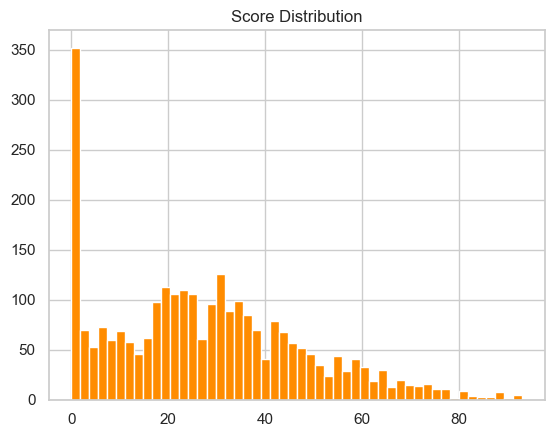

In [ ]:
# Although our data has been fully cleaned and preprocessed before being passed into the model, 
# all feature values ​​and label values ​​have been processed, and outliers and missing values ​​have been removed or reasonably filled.
# However, the sample distribution is not balanced, and there are large differences between categories, 
# so stratified K-fold cross validation is used, which is the default cross validation method of the create_cv_splitter function.
cv = create_cv_splitter()
models, oof_preds_dict = train_models(final_train, final_test, cv, re_tuned=True)

2025-04-16 00:53:30,176 - INFO - Total reduced features: 39


Fold 0: Kappa = 0.4323376741644659
Fold 1: Kappa = 0.4808604871875989
Fold 2: Kappa = 0.43764722322034577
Fold 3: Kappa = 0.4896518712629504
Fold 4: Kappa = 0.41924228418143794
Mean CV Kappa: 0.451948
Std CV: 0.027987
Fold 0: Kappa = 0.45846058105631937
Fold 1: Kappa = 0.5128625809442204
Fold 2: Kappa = 0.43032279892999503
Fold 3: Kappa = 0.4737996223799623
Fold 4: Kappa = 0.4330773814398635
Mean CV Kappa: 0.461705
Std CV: 0.030260
Fold 0: Kappa = 0.48640898781333364
Fold 1: Kappa = 0.5117381947220563
Fold 2: Kappa = 0.4359587538394032
Fold 3: Kappa = 0.4672737065056328
Fold 4: Kappa = 0.39775606857622203
Mean CV Kappa: 0.459827
Std CV: 0.039697


2025-04-16 00:54:07,604 - INFO - Overall Mean Kappa: 0.457827


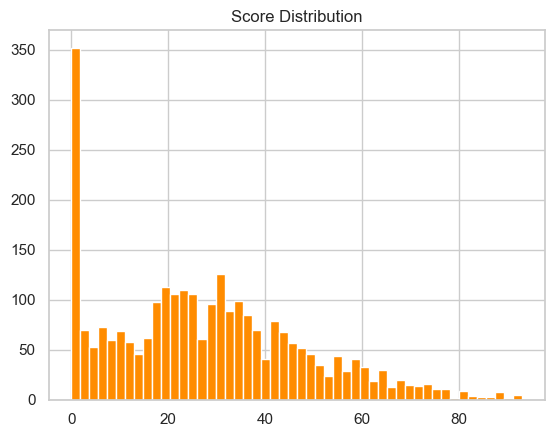

In [122]:
models, oof_preds_dict, test_preds_dict, thresholds_dict = train_models(final_train, final_test, cv, re_tuned=False)


🎯 Built-in Feature Importance: LGBM


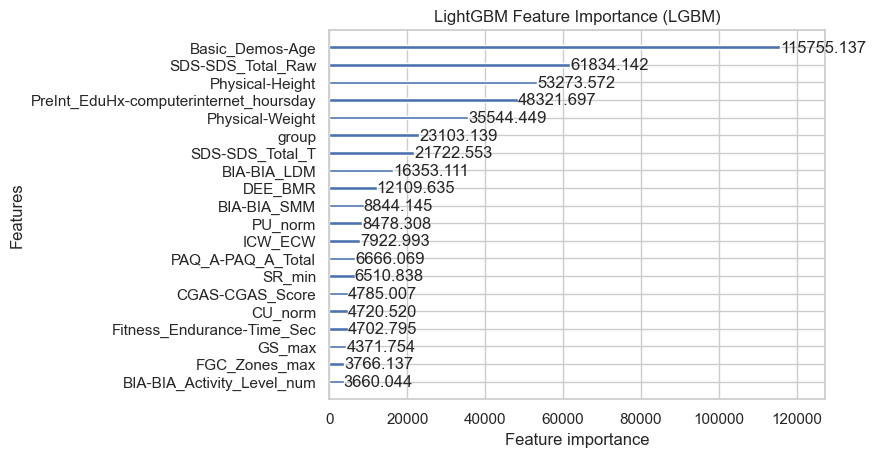


🎯 Built-in Feature Importance: XGB


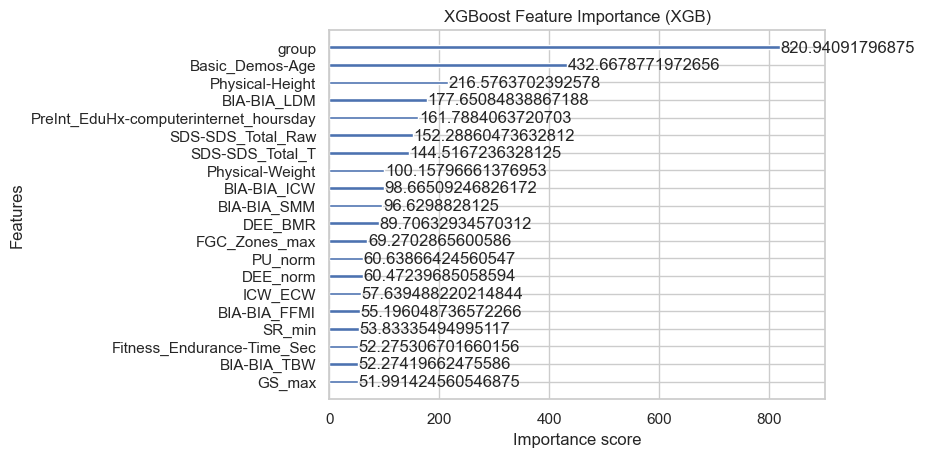


🎯 Built-in Feature Importance: CatBoost


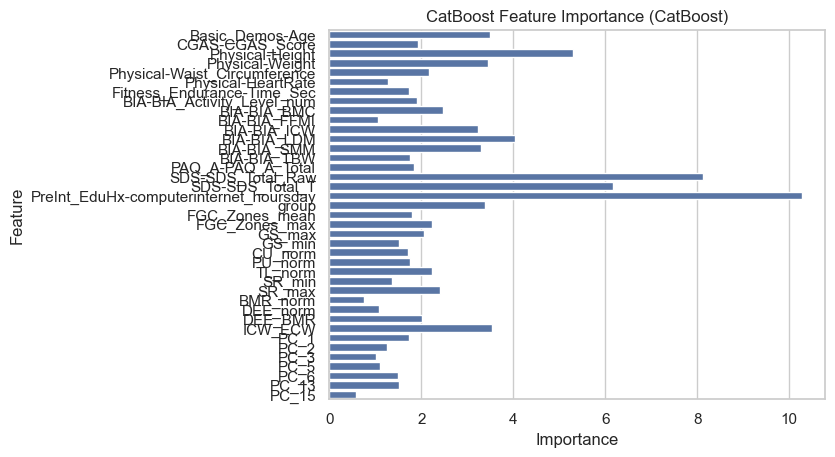

In [123]:
# Plots the global feature contribution plots for LightGBM, XGBoost, and CatBoost using their built-in plot_importance respectively.
plot_builtin_feature_importance(models)

In [124]:
# Comparing the feature importance of three models using ELI5
compare_feature_contribution_eli5(
    models,
    final_train,  
    final_train["PCIAT-PCIAT_Total"]  
)


 ELI5 Permutation Importance for LGBM


Weight,Feature
0.1037 ± 0.0109,PreInt_EduHx-computerinternet_hoursday
0.0273 ± 0.0160,Physical-Height
0.0273 ± 0.0120,Basic_Demos-Age
0.0241 ± 0.0113,SDS-SDS_Total_Raw
0.0131 ± 0.0122,Physical-Weight
0.0120 ± 0.0033,SDS-SDS_Total_T
0.0074 ± 0.0029,SR_min
0.0062 ± 0.0067,BIA-BIA_LDM
0.0054 ± 0.0094,PU_norm
0.0036 ± 0.0050,group



 ELI5 Permutation Importance for XGB


Weight,Feature
0.0947 ± 0.0062,PreInt_EduHx-computerinternet_hoursday
0.0306 ± 0.0152,Basic_Demos-Age
0.0294 ± 0.0113,SDS-SDS_Total_Raw
0.0279 ± 0.0145,Physical-Height
0.0096 ± 0.0103,Physical-Weight
0.0086 ± 0.0089,BIA-BIA_LDM
0.0062 ± 0.0047,SR_min
0.0060 ± 0.0026,SDS-SDS_Total_T
0.0050 ± 0.0074,PU_norm
0.0043 ± 0.0057,group



 ELI5 Permutation Importance for CatBoost


Weight,Feature
0.0943 ± 0.0098,PreInt_EduHx-computerinternet_hoursday
0.0290 ± 0.0177,SDS-SDS_Total_Raw
0.0253 ± 0.0112,Physical-Height
0.0156 ± 0.0040,BIA-BIA_LDM
0.0102 ± 0.0109,group
0.0099 ± 0.0082,BIA-BIA_ICW
0.0092 ± 0.0073,Basic_Demos-Age
0.0080 ± 0.0053,SR_min
0.0062 ± 0.0035,SR_max
0.0055 ± 0.0043,PAQ_A-PAQ_A_Total


Kappa Scores (using model-specific optimal thresholds):
LGBM: 0.4684
XGB: 0.4676
CatBoost: 0.4604


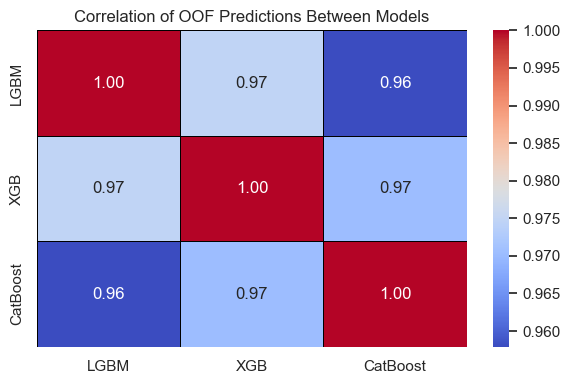

In [125]:
# Visual comparison of model performance
compare_model_performance(final_train, oof_preds_dict, thresholds_dict)

The values in the figure above represent the Pearson correlation coefficients between the out-of-fold (OOF) predictions for each sample across different models. These correlations reflect the consistency in prediction trends across models for each sample, regardless of whether the predictions are correct.

A correlation range of 0.90 to 1.00 indicates that the models are highly similar—almost redundant.
For model ensembling, whether using weighted averaging, stacking, or blending, an important prerequisite is that the prediction errors of the models are complementary rather than redundant. A correlation between 0.40 and 0.70 generally suggests higher potential for ensembling.

However, since the goal of this project is to become familiar with the entire machine learning pipeline, we proceeded with model ensembling regardless.

In [108]:
meta_model_name, meta_model = evaluate_meta_models(pd.DataFrame(oof_preds_dict), final_train["PCIAT-PCIAT_Total"], cv=5, scoring="r2")


Cross-validated performance of candidate meta-models:
Ridge: mean r2 = 0.2853
Lasso: mean r2 = 0.2853
LinearRegression: mean r2 = 0.2853
RandomForest: mean r2 = 0.2769
GBDT: mean r2 = 0.2001
NeuralNet: mean r2 = 0.2861

 Best meta-model: NeuralNet


The selection of meta-models should not be based solely on evaluation metrics like 
$R^2$, but also on the suitability of each method to the data and task.

Neural Network
Although the Neural Network achieved the highest $R^2$ score, it typically requires a large training dataset and involves many parameters. Our dataset, with a shape of (2736, 83), is relatively small to medium-sized, which can easily lead to overfitting when using neural networks.

Interestingly, Ridge, Lasso, and Linear Regression all achieved very similar $R^2$ scores, with only a slight gap compared to the Neural Network.

Linear Regression
Suitable when the number of base models is small and we don't want to penalize any model's contribution.

Ridge Regression
Penalizes models with excessively large weights, helping to mitigate overfitting. It’s particularly appropriate in scenarios with high multicollinearity.

Lasso Regression
Adds an $L_1$ penalty to encourage sparsity, making it ideal when we have many base models and want to retain only the most important ones.

In our case, we have only three base models, and they perform similarly in terms of Kappa scores, making Ridge regression the most appropriate choice for model ensembling.

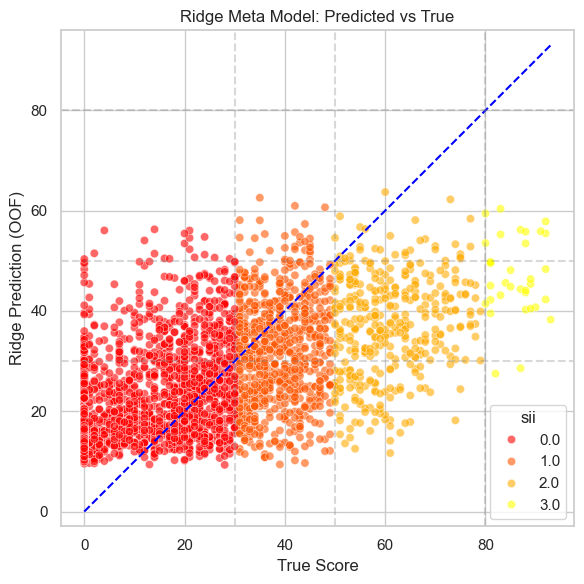

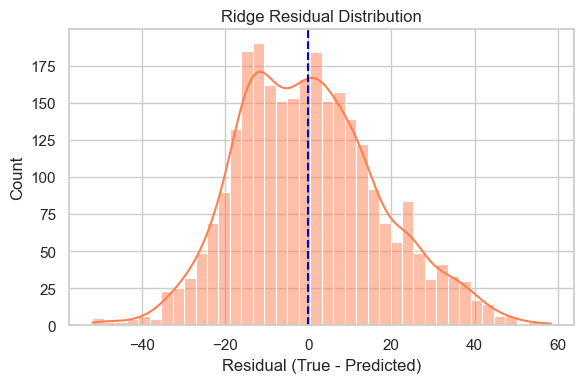

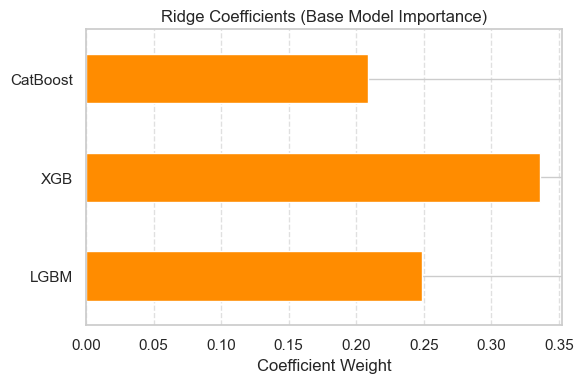

✅ Quadratic Cohen's Kappa (Ridge OOF): 0.4054


In [107]:
meta_model = Ridge(alpha=1.0, fit_intercept=False)
meta_model.fit(pd.DataFrame(oof_preds_dict), final_train["PCIAT-PCIAT_Total"])
meta_model.predict(pd.DataFrame(test_preds_dict))

plot_ridge_meta_model(meta_model, oof_preds_dict, final_train)